In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

class AdaBoost:

    def __init__(self, n_estimators):
        self.base = []
        self.n_estimators = n_estimators
        self.alpha = np.zeros(n_estimators)
        
    def fit(self, X, y):
        length = X.shape[0]
        D = np.ones(length) / length
        # training
        for t in range(self.n_estimators):
            clf = DecisionTreeClassifier()#criterion="entropy", splitter="random", ccp_alpha=0.001)
            clf = clf.fit(X, y, sample_weight = D)
            y_pred = clf.predict(X)
            error = 1 - clf.score(X, y, sample_weight = D)
            
            if error > 0.5:
                break
            elif error == 0:
                self.base.append(clf)
                self.alpha[t] = 1
                break
                
            self.base.append(clf)
            self.alpha[t] = 0.5 * np.log((1 - error) / error)
            D = D * np.exp(-self.alpha[t]*y_pred*y)
            D = D / np.sum(D)
    
    def predict(self, X):
        H = np.zeros(X.shape[0])
        #prob = np.zeros(X.shape[0])
        for t in range(len(self.base)):
                H += self.alpha[t]*self.base[t].predict(X)
            
        H[H>=0] = 1
        H[H<0] = -1
        return H
    
    def predict_proba(self, X):
        prob = np.zeros(X.shape[0])
        for t in range(len(self.base)):
            prob += (self.alpha[t]/self.alpha.sum())*self.base[t].predict_proba(X)[:,1]
            
        return prob
    
    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

def crossValidation(X, y):
    kf = StratifiedKFold(n_splits=5)
    x_axis =[]
    y_axis = []
    for t in range(1, 51):# test n_estimators
        AUC = 0
        x_axis.append(t)
        for train_index, val_index in kf.split(X,y):
            train_data, val_data = X[train_index], X[val_index]
            train_label, val_label = y[train_index], y[val_index]
            clf = AdaBoost(n_estimators=t)
            clf.fit(train_data,train_label)
            pred = clf.predict(val_data)
            prob = clf.predict_proba(val_data)
            AUC += roc_auc_score(val_label, prob)
        AUC /= 5
        y_axis.append(AUC)
        print("NUM = ",t," Valiadtion AUC = ", AUC)
    return x_axis, y_axis
    
if __name__ == "__main__":
    # load data from source
    X_train = np.genfromtxt("adult_dataset/adult_train_feature.txt")
    X_test  = np.genfromtxt("adult_dataset/adult_test_feature.txt")
    y_train = np.genfromtxt("adult_dataset/adult_train_label.txt")
    y_test  = np.genfromtxt("adult_dataset/adult_test_label.txt")
    # preprocess
    y_train = (y_train - 0.5) * 2
    y_test = (y_test - 0.5) * 2    
    # train & predict
    clf = AdaBoost(n_estimators = 50)
    clf.fit(X_train, y_train)
    print(clf.score(X_test,y_test))
    
    #print(clf.predict_proba(X_test))
    #print(clf.predict(X_test))
    #print("(Adaboost) accuracy on testing set: ",clf.score(X_test, y_test))
    #x1,y1 = crossValidation(X_train,y_train)
    
    #pred = clf.predict(X_test)
    #prob = clf.predict_proba(X_test)
    #res = roc_auc_score(y_test, prob)
    #print("NUM=30, AUC=", res)
    
    # plot
    #plt.plot(x1,y1,',-',label='AdaBoost')
    #plt.xlabel("num of learners")
    #plt.ylabel("Validation AUC")
    #plt.legend()
    #plt.show()

0.8142006019286284


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

class RandomForest:
    
    def __init__(self, n_estimators):
        self.base = []
        self.n_estimators = n_estimators
    
    def bootstrap_sample(self, X, y):
        len = X.shape[0]
        y = y.reshape(len,1)
        X_y = np.hstack((X,y))
        np.random.shuffle(X_y)
        
        dataset = []
        for t in range(self.n_estimators):
            idm = np.random.choice(len, len, replace=True) # 有放回
            bootstrap_X_y = X_y[idm,:]
            bootstrap_X =  bootstrap_X_y[:,:-1]
            bootstrap_y =  bootstrap_X_y[:,-1:]
            dataset.append([bootstrap_X,bootstrap_y])
        return dataset
    
    def fit(self, X, y):
        # 自助采样
        sample = self.bootstrap_sample(X, y)
        for t in range(self.n_estimators):
            X_sub, y_sub = sample[t]
            clf = DecisionTreeClassifier(max_features="log2")#, ccp_alpha=0.0001)
            clf.fit(X_sub, y_sub)
            self.base.append(clf)    
                
    def predict(self, X):
        m = X.shape[0]
        votes = np.zeros((m, self.n_estimators)).astype(int)
        for j in range(self.n_estimators):
            votes[:,j] = self.base[j].predict(X)
        y_pred = np.zeros(m).astype(int)
        for i in range(m):
            (values,counts) = np.unique(votes[i, :],return_counts=True)
            y_pred[i] = values[counts.argmax()]
        return y_pred
    
    def predict_proba(self, X):
        m = X.shape[0]
        votes = np.zeros((m, self.n_estimators))
        for j in range(len(self.base)):
            votes[:,j] = self.base[j].predict_proba(X)[:,1]
        prob = np.zeros(m)
        for i in range(m):
            prob[i] = votes[i, :].sum()/self.n_estimators
        return prob
    
        def score(self, X, y, sample_weight=None):
            return accuracy_score(y, self.predict(X), sample_weight=sample_weight)     

def crossValidation(X, y):
    kf = StratifiedKFold(n_splits=5)
    x_axis = []
    y_axis = []
    
    for t in range(1, 51):# test n_estimators
        AUC = 0
        x_axis.append(t)
        for train_index, val_index in kf.split(X,y):
            train_data, val_data = X[train_index], X[val_index]
            train_label, val_label = y[train_index], y[val_index]
            clf = RandomForest(n_estimators=t)
            clf.fit(train_data,train_label)
            pred = clf.predict(val_data)
            prob = clf.predict_proba(val_data)
            AUC += roc_auc_score(val_label, prob)
        AUC /= 5
        y_axis.append(AUC)
        print("NUM = ",t," Valiadtion AUC = ", AUC)
    return x_axis, y_axis
    
if __name__ == "__main__":
    # load data from source
    X_train = np.genfromtxt("adult_dataset/adult_train_feature.txt")
    X_test  = np.genfromtxt("adult_dataset/adult_test_feature.txt")
    y_train = np.genfromtxt("adult_dataset/adult_train_label.txt")
    y_test  = np.genfromtxt("adult_dataset/adult_test_label.txt")
    # preprocess
    y_train = (y_train - 0.5) * 2
    y_test = (y_test - 0.5) * 2
    # train & predict
    clf = RandomForest(n_estimators = 50)
    clf.fit(X_train, y_train)
    print("(RandomForest) accuracy on testing set: ",clf.score(X_test, y_test))
    
    # cross-validation
    #x2,y2 = crossValidation(X_train, y_train)
    
    # auc for optimal n_estimator
    #pred = clf.predict(X_test)
    #prob = clf.predict_proba(X_test)
    #res = roc_auc_score(y_test, prob)
    #print("NUM=46, AUC=", res)
    
    # plot
    #plt.plot(x2,y2,',-',label='RandomForest')
    #plt.xlabel("num of learners")
    #plt.ylabel("Validation AUC")
    #plt.legend()
    #plt.show()

NUM=46, AUC= 0.9004814008402717


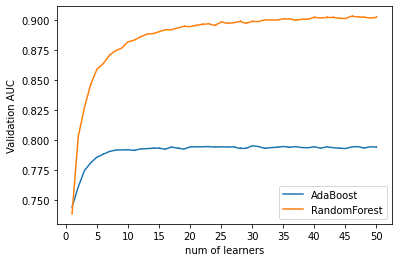

In [32]:
plt.plot(x1,y1,',-',label='AdaBoost')
plt.plot(x2,y2,',-',label='RandomForest')
plt.xlabel("num of learners")
plt.ylabel("Validation AUC")
my_x_ticks = np.arange(0, 55, 5)
plt.xticks(my_x_ticks)
#plt.title("")
plt.legend()
plt.savefig("stat.jpg",dpi=600)
plt.show()